In [1]:
import sys
import os
import pylab as plt
from matplotlib.colors import ListedColormap
import numpy as np
import math
from osgeo import gdal
import skimage

sys.path.insert(0, '../src')
import deepgeo.dataset.data_augment as dtaug
import deepgeo.dataset.rasterizer as rstzr

/home/raian/anaconda3/envs/tensorflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Input Files
DATA_DIR = os.path.join(os.path.abspath(os.path.dirname("__file__")), '../', 'data_real')
shape_file = os.path.join(DATA_DIR, 'PRODES2016_225-64_REP.shp')
#raster_file = os.path.join(DATA_DIR, "Landsat8_225-64_17-07-2016-R6G5B4.tif")
raster_file = os.path.join(DATA_DIR, "Landsat8_225-64_17-07-2016-B1-7.tif")
class_column = "agregClass"

window_size = 128

In [3]:
img_ds = gdal.Open(raster_file)
img = img_ds.ReadAsArray()
print(img.shape)
img = np.rollaxis(img, 0, start=3)
img = skimage.img_as_float(img).astype(np.float32)
print(img.shape)

(7, 7741, 7591)
(7741, 7591, 7)


In [4]:
#hist_ndvi = plt.hist(img.ravel(), bins=256)

(-0.5, 7590.5, 7740.5, -0.5)

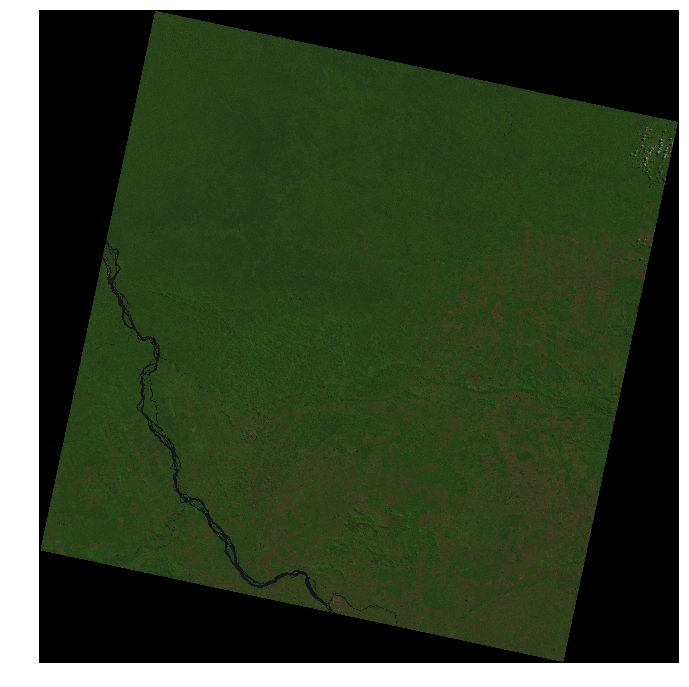

In [5]:
plt.figure(figsize=(12,12))
plt.imshow(img[:,:,[5, 4, 3]])
plt.axis('off')

## Rasterize the Input Shape File

In [6]:
rasterizer = rstzr.Rasterizer(shape_file, raster_file, class_column)
rasterizer.collect_class_names()
rasterizer.rasterize_layer()
class_names = rasterizer.get_class_names()
rasterized_layer = rasterizer.get_labeled_raster()

Raster Shape: (7741, 7591, 1)


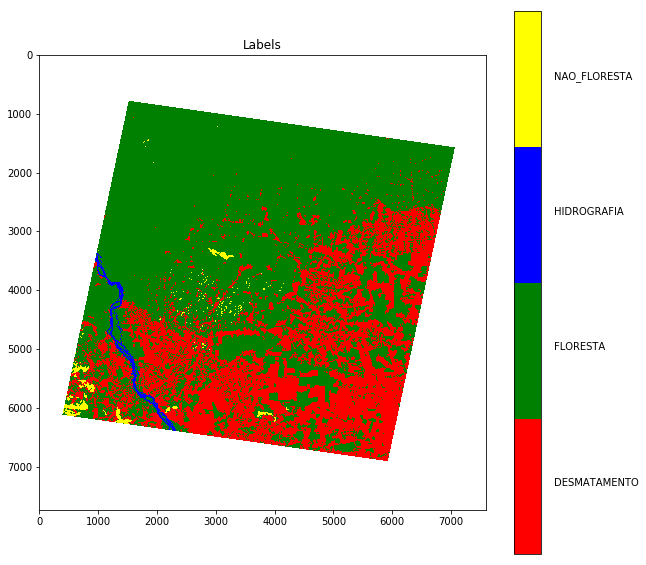

In [7]:
plt.figure(figsize=(10, 10))
plt.title('Labels')
print("Raster Shape:", rasterized_layer.shape)
labels = np.ma.masked_where(rasterized_layer == 255, rasterized_layer)

colorMap = ListedColormap(["red", "green", "blue", "yellow"])
plt.imshow(rasterized_layer[:,:,0], cmap=colorMap)
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])

for j, lab in enumerate(class_names):
    cbar.ax.text(1.5, (2 * j + 1) / 8, lab, ha='left')

cbar.ax.get_yaxis().labelpad = 15

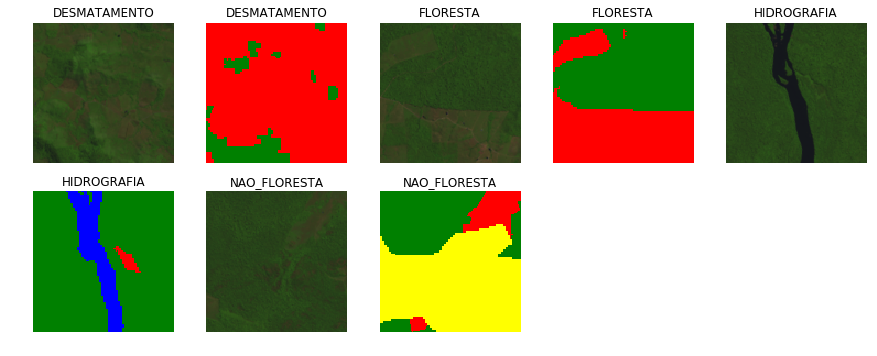

In [9]:
plt.figure(figsize=(15,15))

win_1 = math.floor(window_size / 2)
win_2 = math.ceil(window_size / 2)
count = 1

colorList = ["red", "green", "blue", "yellow"]

patches_img = []
patches_lbl = []

for lid, cname in enumerate(class_names):
    candidates = np.transpose(np.nonzero(rasterized_layer == lid))
    ij = candidates[np.random.randint(candidates.shape[0])]
    
    subimg = img[ij[0]-win_1:ij[0]+win_2,ij[1]-win_1:ij[1]+win_2]
    
    plt.subplot(5, 5, count)
    plt.title(cname)
    plt.axis('off')
    count += 1
    plt.imshow(subimg[:, :,[5, 4, 3]], interpolation='nearest')
    
    subimg2 = rasterized_layer[ij[0]-win_1:ij[0]+win_2,ij[1]-win_1:ij[1]+win_2]
    
    palette = []
    for val in np.unique(subimg2):
        if not val == 255:
            palette.append(colorList[val])
    colorMap = ListedColormap(palette)
    
    plt.subplot(5, 5, count)
    plt.title(cname)
    plt.axis('off')
    count += 1
    plt.imshow(subimg2[:,:,0], interpolation='nearest', cmap=colorMap)
    
    patches_img.append(subimg)
    patches_lbl.append(subimg2)

# Cells bellow here make the data augmentation

The Data Augmentation must be done when generating the dataset or when training the network? Put the samples generated with data augmentation in the dataset generate them on the fly?

## About the implementation
The data augmentation over the samples must be done together with the labels. How to ensure the order in the dataset?

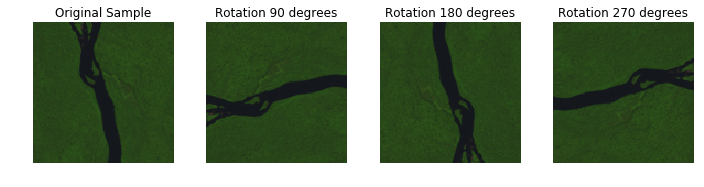

In [12]:
angles = [90, 180, 270]
rotated_imgs = dtaug.rotate_images([patches_img[2]], angles)
#rotated_lbl = dtaug.rotate_images([patches_lbl[2]], angles)

plt.figure(figsize=(15,15))

plt.subplot(5, 5, 1)
plt.title('Original Sample')
plt.imshow(patches_img[2][:,:,[5, 4, 3]], interpolation='nearest')
plt.axis('off')

pos_ang = 0
for idx in range(len(rotated_imgs)):
    plt.subplot(5, 5, idx + 2)
    plt.title("Rotation %d degrees" % (angles[idx]))
    plt.imshow(rotated_imgs[idx][:,:,[5, 4, 3]], interpolation='nearest')
    plt.axis('off')

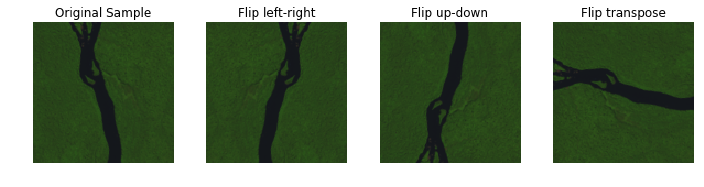

In [14]:
flipped_imgs = dtaug.flip_images([patches_img[2]])
#rotated_lbl = dtaug.rotate_images([patches_lbl[2]], angles)

plt.figure(figsize=(15,15))

plt.subplot(5, 5, 1)
plt.title('Original Sample')
plt.imshow(patches_img[2][:,:,[5, 4, 3]], interpolation='nearest')
plt.axis('off')

flip_directions = ["left-right", "up-down", "transpose"]
for idx in range(len(rotated_imgs)):
    plt.subplot(5, 5, idx + 2)
    plt.title("Flip %s" % flip_directions[idx])
    plt.imshow(flipped_imgs[idx][:,:,[5, 4, 3]], interpolation='nearest')
    plt.axis('off')